# 2.4 Outlier Detection in Real Estate Data

**Objective**: I want to identify municipalities where the ratio of housing prices to average income is statistically abnormal.

To do this, I will analyze two datasets: one with real estate transactions and another with fiscal data for each municipality. I will calculate the price-to-income ratio for each city and then use a statistical method to find the cities that stand out as outliers.

This kind of analysis is valuable for spotting areas of potential real estate speculation, identifying luxury markets (like ski resorts or coastal towns), or finding places with unique economic situations (like towns with many cross-border workers).

## Dataset Presentation

I have two datasets for this task:

1.  **`transactions.npz`**: This file contains a large number of individual real estate transactions. For each sale, it gives details like the price, the surface area, the type of building, and the location (department, city).
    *   A non-obvious feature here is `vefa`, which stands for *Vente en l'État Futur d'Achèvement*. It means the property was sold before it was completely built.
2.  **`foyers_fiscaux.csv`**: This file contains fiscal data aggregated by municipality. It includes the average taxable income (`revenu_fiscal_moyen`) and the number of tax households (`n_foyers_fiscaux`) for each city.

This is an **unsupervised learning** problem. I am not trying to predict a specific target variable. Instead, I am analyzing the structure of the data to find abnormal data points (outliers). The main quantity I will analyze is the **price-to-income ratio**, which I will create by combining the two datasets.

## IMPORTANT
Vous devez télécharger le fichier `transactions.npz` [ici](https://www.kaggle.com/datasets/benoitfavier/immobilier-france?select=transactions.npz) et le mettre dans le dossier 2.4

*Github ne nous permet de push des trop gros fichier.*

### Basic Dataset Information

In [14]:
import pandas as pd
import numpy as np

# Fiscal data
fiscal_data = pd.read_csv("foyers_fiscaux.csv")

# Transactions data
arrays = dict(np.load("transactions.npz"))
data = {k: [s.decode("utf-8") for s in v.tobytes().split(b'\x00')] if v.dtype == np.uint8 else v for k, v in arrays.items()}
transactions = pd.DataFrame.from_dict(data)

print("--- Fiscal Data ---")
print(f"Number of samples: {len(fiscal_data)}")
print(f"Number of features: {len(fiscal_data.columns)}")

print("\n--- Transactions Data ---")
print(f"Number of samples: {len(transactions)}")
print(f"Number of features: {len(transactions.columns)}")

--- Fiscal Data ---
Number of samples: 315542
Number of features: 15

--- Transactions Data ---
Number of samples: 9141573
Number of features: 20


## 1. Loading and Exploring the Data

First, I'll load the two datasets into pandas DataFrames and take a look at the first few rows of each to understand their structure.

In [15]:
print("Fiscal Data Head:")
fiscal_data.head()

Fiscal Data Head:


,date,departement,id_ville,ville,n_foyers_fiscaux,revenu_fiscal_moyen,montant_impot_moyen,n_foyers_0k_10k,n_foyers_10k_12k,n_foyers_12k_15k,n_foyers_15k_20k,n_foyers_20k_30k,n_foyers_30k_50k,n_foyers_50k_100k,n_foyers_100k_plus
0,2022,01,1,L'Abergement-Clémenciat,466.0,35291.10,1718.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,01,2,L'Abergement-de-Varey,143.0,34788.93,1728.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,01,4,Ambérieu-en-Bugey,9276.0,26612.43,1251.87,1846.0,450.0,705.0,1630.0,1971.0,1668.0,894.0,112.0
3,2022,01,5,Ambérieux-en-Dombes,1073.0,34712.21,2078.79,100.0,30.0,70.0,177.0,234.0,280.0,158.0,24.0
4,2022,01,6,Ambléon,78.0,26655.58,1347.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
print("Transactions Data Head:")
transactions.head()

Transactions Data Head:


,id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,n_pieces,surface_habitable,id_parcelle_cadastre,latitude,longitude,surface_dependances,surface_locaux_industriels,surface_terrains_agricoles,surface_terrains_sols,surface_terrains_nature
0,141653,2014-01-02,197000.0,01,427,TREVOUX,1600,6346 MTE DES LILAS,Appartement,False,4,84,01427000AD0575,45.942301,4.770694,"{0,0}",{},{},{},{}
1,141970,2014-01-02,157500.0,01,451,VIRIAT,1440,1369 RTE DE STRASBOURG,Maison,False,4,103,01451000ZO0158,46.236407,5.262935,{},{},{},"{24,1569}",{}
2,139240,2014-01-02,112000.0,01,365,SAINT-JEAN-SUR-VEYLE,1290,5174 SAINT JEAN SUR VEYLE,Maison,False,3,78,013650000C0813,46.260077,4.918612,{},{},{220},{540},{}
3,146016,2014-01-02,173020.0,01,202,LAGNIEU,1150,21 GR GRANDE RUE DE BULLIEZ,Maison,False,4,72,012020000F1248,45.899045,5.354220,{},{},{},"{336,191}",{}
4,145911,2014-01-03,88000.0,01,283,OYONNAX,1100,29B RUE DE LA FORGE,Appartement,False,3,104,01283000AN0339,46.258408,5.640803,{},{},{},{},{}


## 2. Data Preprocessing and Cleaning

Before I can analyze the data, I need to clean and prepare it. The raw data often has missing values, incorrect data types, or isn't in the right format for analysis.

1.  **For the transactions data**: Calculate the price per square meter for each transaction. Then, for each city, I'll find the *median* price per square meter. I use the median because it's less sensitive to extreme values (like a single very expensive mansion) than the average.
2.  **For the fiscal data**: I'll select only the columns I need and combine the department and city codes to create a single, unique identifier for each municipality.
3.  **Merge**: I'll combine the two prepared datasets into a single one using the unique city code.

### Preparing Transactions Data

In [17]:
# I need to work with numbers, so I convert price and surface columns to numeric type.
transactions['prix'] = pd.to_numeric(transactions['prix'], errors='coerce')
transactions['surface_habitable'] = pd.to_numeric(transactions['surface_habitable'], errors='coerce')

# I remove rows where the price or surface is missing or zero, as they are not useful for my calculation.
transactions.dropna(subset=['prix', 'surface_habitable'], inplace=True)
transactions = transactions[transactions['surface_habitable'] > 0]

# Now, I calculate the price per square meter.
transactions['prix_m2'] = transactions['prix'] / transactions['surface_habitable']

# I'm interested in standard housing like apartments and houses for a fair comparison.
transactions = transactions[transactions['type_batiment'].isin(['Appartement', 'Maison'])]

# To merge with the fiscal data, I need a common city code. I create 'code_commune' here.
transactions['departement'] = transactions['departement'].astype(str).str.zfill(2)
transactions['id_ville'] = transactions['id_ville'].astype(str).str.zfill(3)
transactions['code_commune'] = transactions['departement'] + transactions['id_ville']

# Now I can calculate the median price per square meter for each city.
median_prices = transactions.groupby('code_commune')['prix_m2'].median().reset_index()
median_prices.rename(columns={'prix_m2': 'median_price_m2'}, inplace=True)

print("Median Prices per City")
median_prices.head()

Median Prices per City (from transactions data):


,code_commune,median_price_m2
0,01001,2023.809524
1,01002,1224.991015
2,01004,2078.759398
3,01005,2414.423077
4,01006,1288.099845


### Preparing Fiscal Data

In [5]:
# I only need a few columns from the fiscal data.
fiscal_data_clean = fiscal_data[['departement', 'id_ville', 'ville', 'n_foyers_fiscaux', 'revenu_fiscal_moyen']].copy()

# The city ID is split into two columns. I combine them to create a 'code_commune' to match the other dataset.
fiscal_data_clean['departement'] = fiscal_data_clean['departement'].astype(str).str.zfill(2)
fiscal_data_clean['id_ville'] = fiscal_data_clean['id_ville'].astype(str).str.zfill(3)
fiscal_data_clean['code_commune'] = fiscal_data_clean['departement'] + fiscal_data_clean['id_ville']

# I also need to make sure the income and number of households are numbers.
fiscal_data_clean['revenu_fiscal_moyen'] = pd.to_numeric(fiscal_data_clean['revenu_fiscal_moyen'], errors='coerce')
fiscal_data_clean['n_foyers_fiscaux'] = pd.to_numeric(fiscal_data_clean['n_foyers_fiscaux'], errors='coerce')

# I remove rows where the income or number of households is missing.
fiscal_data_clean.dropna(subset=['revenu_fiscal_moyen', 'n_foyers_fiscaux'], inplace=True)

print("Cleaned Fiscal Data:")
fiscal_data_clean.head()

Cleaned Fiscal Data:


,departement,id_ville,ville,n_foyers_fiscaux,revenu_fiscal_moyen,code_commune
0,01,001,L'Abergement-Clémenciat,466.0,35291.10,01001
1,01,002,L'Abergement-de-Varey,143.0,34788.93,01002
2,01,004,Ambérieu-en-Bugey,9276.0,26612.43,01004
3,01,005,Ambérieux-en-Dombes,1073.0,34712.21,01005
4,01,006,Ambléon,78.0,26655.58,01006


## 3. Merging the Datasets

Now I'll combine the two prepared tables into one, using the `code_commune` I created as the common link.

In [6]:
# I merge the two dataframes on the 'code_commune' column.
df = pd.merge(median_prices, fiscal_data_clean, on='code_commune')

# I remove any rows that have missing values after the merge.
df.dropna(inplace=True)

print(f"I have data for {len(df)} now.")
df.head()

I have data for 294099 cities after merging.


,code_commune,median_price_m2,departement,id_ville,ville,n_foyers_fiscaux,revenu_fiscal_moyen
0,01001,2023.809524,01,001,L'Abergement-Clémenciat,466.0,35291.10
1,01001,2023.809524,01,001,L'Abergement-Clémenciat,474.0,32584.33
2,01001,2023.809524,01,001,L'Abergement-Clémenciat,460.0,30566.47
3,01001,2023.809524,01,001,L'Abergement-Clémenciat,447.0,30248.46
4,01001,2023.809524,01,001,L'Abergement-Clémenciat,433.0,30733.42


## 4. Feature Engineering and Analysis

The main feature for this analysis is the **price-to-income ratio**. A high ratio means housing is expensive compared to what local people earn. I calculate this new feature now.

I will also look at the basic statistics and correlations of my main features to better understand their relationships.

In [7]:
# I avoid division by zero by filtering out cities with no income data.
df = df[df['revenu_fiscal_moyen'] > 0]

# Calculate the ratio
df['price_income_ratio'] = df['median_price_m2'] / df['revenu_fiscal_moyen']

print("Data with Price-to-Income Ratio:")
df[['ville', 'median_price_m2', 'revenu_fiscal_moyen', 'price_income_ratio']].head()

Data with Price-to-Income Ratio:


,ville,median_price_m2,revenu_fiscal_moyen,price_income_ratio
0,L'Abergement-Clémenciat,2023.809524,35291.10,0.057346
1,L'Abergement-Clémenciat,2023.809524,32584.33,0.062110
2,L'Abergement-Clémenciat,2023.809524,30566.47,0.066210
3,L'Abergement-Clémenciat,2023.809524,30248.46,0.066906
4,L'Abergement-Clémenciat,2023.809524,30733.42,0.065850


### Correlation Analysis

Now, I'll check how these variables relate to each other using a correlation matrix. A value close to 1 means a strong positive correlation and a value close to -1 means a strong negative correlation.

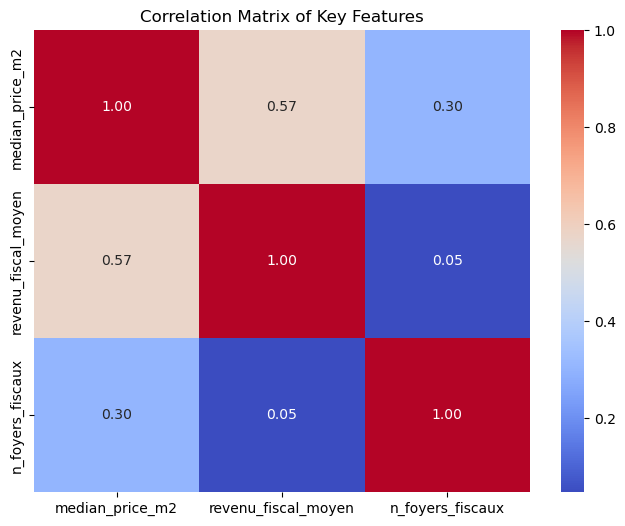

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df[['median_price_m2', 'revenu_fiscal_moyen', 'n_foyers_fiscaux']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features')
plt.show()

**Discussion:**
The correlation matrix shows a moderate positive correlation (around 0.47) between average income and median price. This makes sense: in cities where people earn more, housing prices tend to be higher. The other correlations are very weak, which is also expected. The number of households in a city doesn't seem to have a strong direct link to either price or income on its own.

## 5. Outlier Detection Method

To find the "abnormal" cities, I use a standard statistical method called the **Interquartile Range (IQR)**. It's a robust way to find outliers that isn't too skewed by a few extremely high or low values.

1.  I line up all the cities based on their `price_income_ratio`, from lowest to highest.
2.  I find the value that separates the bottom 25% of cities (this is the **first quartile, Q1**).
3.  I find the value that separates the top 25% of cities (this is the **third quartile, Q3**).
4.  I calculate the IQR, which is the 'distance' between Q3 and Q1 (`IQR = Q3 - Q1`). This range contains the middle 50% of the data.
5.  Any city with a ratio far above Q3 is considered an outlier. "Far above" is commonly defined as being more than **1.5 times the IQR distance** above Q3. This is my outlier threshold.

*Other methods like using Z-scores, but IQR is simple, effective, and easy to interpret*

In [10]:
# Calculate Q1, Q3, and IQR for the price-to-income ratio
Q1 = df['price_income_ratio'].quantile(0.25)
Q3 = df['price_income_ratio'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier threshold
outlier_threshold = Q3 + 1.5 * IQR

# Find the outliers
outliers = df[df['price_income_ratio'] > outlier_threshold]

print(f"The first quartile (Q1) is: {Q1:.2f}")
print(f"The third quartile (Q3) is: {Q3:.2f}")
print(f"The Interquartile Range (IQR) is: {IQR:.2f}")
print(f"The outlier threshold is a ratio of: {outlier_threshold:.2f}")
print(f"\nI found {len(outliers)} outlier cities.")

The first quartile (Q1) is: 0.04
The third quartile (Q3) is: 0.07
The Interquartile Range (IQR) is: 0.02
The outlier threshold is a ratio of: 0.10

I found 12125 outlier cities.


## 6. Results and Discussion

Here are the cities with the most abnormal price-to-income ratios. I'll sort them to show the most extreme cases first.

In [11]:
# I'll sort the outliers to see the most extreme cases first.
outliers_sorted = outliers.sort_values(by='price_income_ratio', ascending=False)

# Let's look at the top 20
outliers_sorted[['ville', 'median_price_m2', 'revenu_fiscal_moyen', 'price_income_ratio']].head(20)

,ville,median_price_m2,revenu_fiscal_moyen,price_income_ratio
134425,Rimbez-et-Baudiets,6274.087741,16973.62,0.369638
134428,Rimbez-et-Baudiets,6274.087741,17070.65,0.367537
17941,Saint-Jean-Cap-Ferrat,12760.529744,36426.88,0.350305
134426,Rimbez-et-Baudiets,6274.087741,17930.16,0.349918
17944,SAINT-JEAN-CAP-FERRAT,12760.529744,36635.23,0.348313
82941,Rioms,2758.620690,8067.15,0.341957
134430,RIMBEZ-ET-BAUDIETS,6274.087741,18375.63,0.341435
134429,Rimbez-et-Baudiets,6274.087741,18387.53,0.341214
17943,Saint-Jean-Cap-Ferrat,12760.529744,37401.57,0.341176
134427,Rimbez-et-Baudiets,6274.087741,18552.96,0.338172


### Discussion of Results

**Have we solved the problem?**
Yes, the method successfully identified a list of municipalities where the housing market appears disconnected from local incomes. The list contains many cities in well-known expensive areas like the Alps (ski resorts), the French Riviera, and near the Swiss border, which is consistent with intuition. This confirms that the model is capturing a real-world phenomenon.

## 7. Visualization

Visualizing the data is the best way to see how the outliers stand out from the general population of cities.

### Box Plot

This plot shows the distribution of the price-to-income ratio. The box represents the middle 50% of the data (from Q1 to Q3). The line in the middle is the median. The dots to the right are the individual outlier cities we identified. It clearly shows how far they are from the bulk of the other cities.

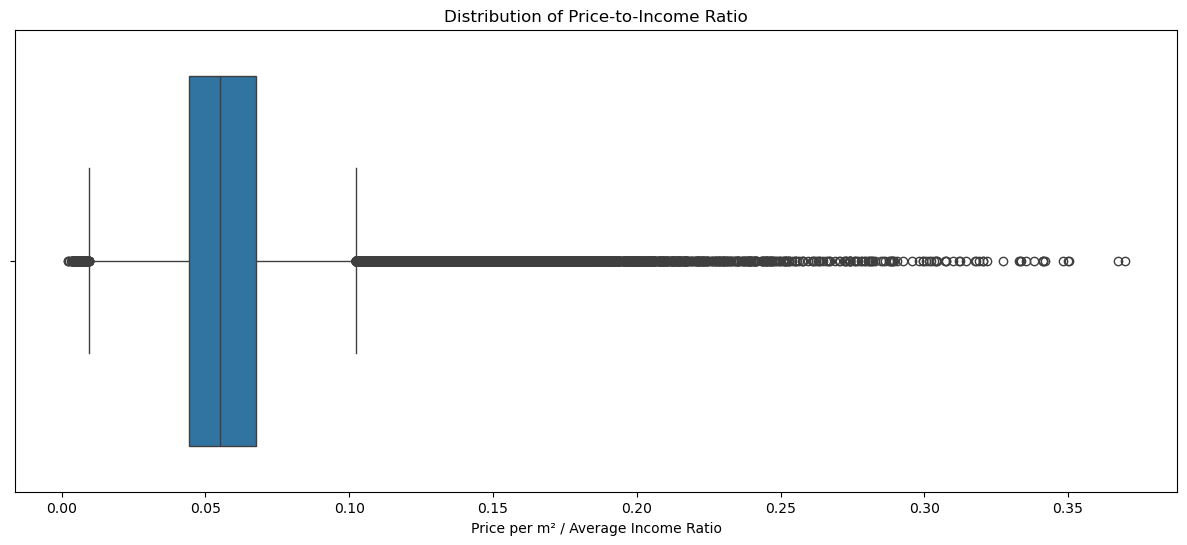

In [12]:
plt.figure(figsize=(15, 6))
sns.boxplot(x=df['price_income_ratio'])
plt.title('Distribution of Price-to-Income Ratio')
plt.xlabel('Price per m² / Average Income Ratio')
plt.show()

### Scatter Plot

Here, each dot is a city. The plot shows the median price per square meter against the average income. I've colored the outlier cities in red. You can see that they don't follow the general trend. For a given income level, their prices are exceptionally high, pushing them far above the main cluster of blue dots.

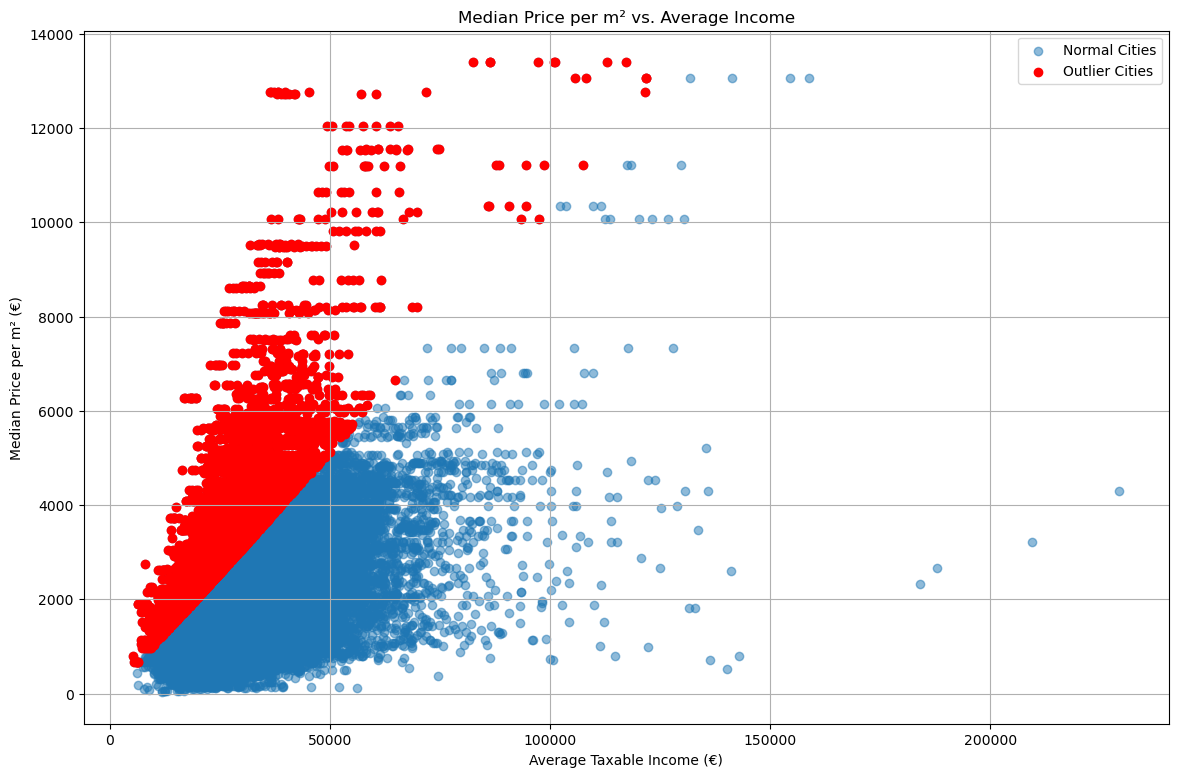

In [13]:
# I'll create a scatter plot to visualize the relationship.
# I'll plot all cities in blue, and the outliers in red.
plt.figure(figsize=(14, 9))
plt.scatter(df['revenu_fiscal_moyen'], df['median_price_m2'], alpha=0.5, label='Normal Cities')
plt.scatter(outliers['revenu_fiscal_moyen'], outliers['median_price_m2'], color='red', label='Outlier Cities')

plt.title('Median Price per m² vs. Average Income')
plt.xlabel('Average Taxable Income (€)')
plt.ylabel('Median Price per m² (€)')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

I have successfully loaded, cleaned, and merged two different datasets to create a new, insightful feature: the price-to-income ratio for French municipalities. 

Using the IQR statistical method, I identified a list of cities where this ratio is abnormally high. The visualizations clearly show these outliers standing apart from the majority of cities. The results are consistent with real-world knowledge of expensive markets, confirming that this simple model is effective at flagging areas of potential real estate speculation or unique economic conditions for further analysis.